In [5]:
import pandas as pd
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [6]:
tf.__version__

'2.0.0-beta1'

In [13]:
def get_event_filename(dir, base='/Users/jeremygordon/Google Drive/Professional/Work Places/Internships Fellowships/2019 Numenta/rsm_highlights/SMNIST/'):
    for path in os.listdir(base + dir):   
        if 'events' in path:    
            return base + dir + '/' + path
    print("No event for %s" % dir)

def get_curve(filename):
    xaxis = []
    accs = []
    losses = []
    rsm = "RSMTune" in filename
    for event in tf.compat.v1.train.summary_iterator(filename):
        if not xaxis or xaxis[-1] != event.step:
            xaxis.append(event.step)
        for value in event.summary.value:
            if 'acc' in value.tag:
                acc = value.simple_value
                accs.append(acc)
            elif 'loss' in value.tag:
                loss = value.simple_value
                losses.append(loss)
    if rsm:
        xaxis = np.array(xaxis) * 100  # As per batches_in_epoch
    return xaxis, accs, losses

LSTM continuous k2=30 Max: 52.743 & 59.342
LSTM mbs:100 k2=30 Max: 57.540 & 64.739
LSTM mbs:50 k2=30 Max: 75.540 & 84.991
LSTM mbs:50 k2=20 Max: 72.807 & 81.916
Adj Partitioned RSM Max: 88.473 & 99.542
Adj RSM Max: 86.057 & 96.823


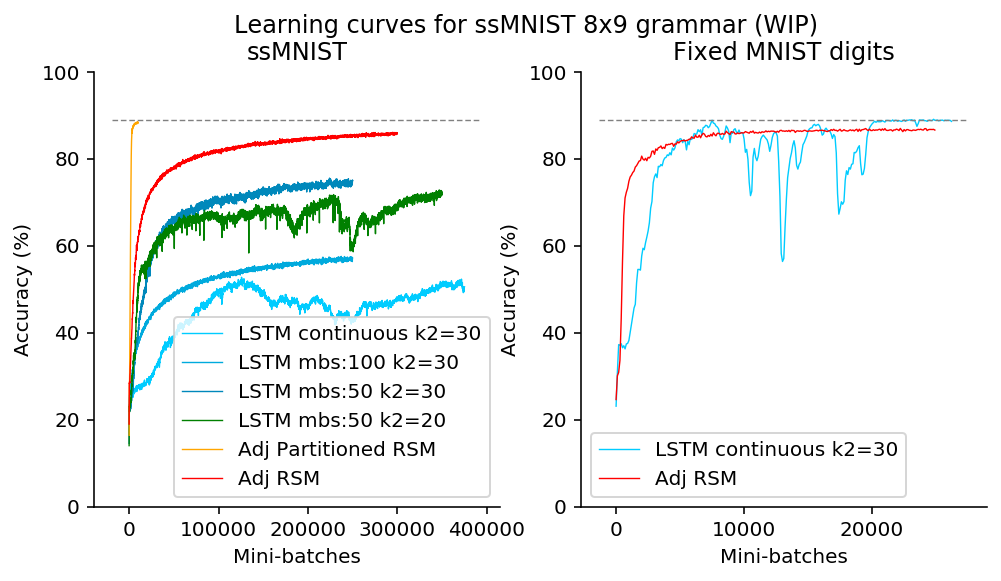

In [17]:
ACC_CEIL = 88.88
fig, axs = plt.subplots(1, 2, dpi=144, figsize=(8, 4))

CHARTS = {
#     "1568393453_mbs-250000_epochs-0_k2-30_fixed-False_noise-False_clip-False": {
#         'label': "LSTM continuous k2=30",
#     },
    "1569437923_mbs-400000_epochs-0_k2-30_fixed-False_noise-False_clip-False_cs-True_lr-2e-05": {
        'label': "LSTM continuous k2=30",
        'color': "#00CCFF"
    },
    "1569191158_mbs-100_epochs-2500_k2-30_fixed-False_noise-False_clip-True_cs-False_lr-1e-05": {
        'label': "LSTM mbs:100 k2=30",
        'color': "#00AADD"        
    },
    "1569267871_mbs-50_epochs-5000_k2-30_fixed-False_noise-False_clip-False_cs-False_lr-2e-05": {
        'label': "LSTM mbs:50 k2=30",
        'color': "#0088BB"                
    },
    "1569351273_mbs-50_epochs-7000_k2-20_fixed-False_noise-False_clip-False_cs-False_lr-2e-05": {
        'label': "LSTM mbs:50 k2=20",
        'color': 'green'
    },
    "RSMTune_0_fpartition__0.07__0.85__2019-09-23_20-03-33n204j69t": {
        'label': "Adj Partitioned RSM",
        'color': 'orange'
    },
    "RSMTune_0_2019-09-27_05-53-057t7gdzwm": {
        'label': "Adj RSM",
        'color': 'red'
    }
}

FIXED_CHARTS = {
    "1568054769_mbs-100000_epochs-0_k2-30_fixed-True_noise-False": {
        'label': "LSTM continuous k2=30",
        'color': "#00CCFF"
    },
    "RSMTune_0_2019-09-25_18-56-52sagiu93e": {
        'label': "Adj RSM",
        'color': 'red'
    },
}

for dir, props in CHARTS.items():
    filename = get_event_filename(dir)
    xaxis, accs, losses = get_curve(filename)
    axs[0].plot(xaxis[:len(accs)], accs, label=props.get('label'), c=props.get('color'), linewidth=0.7)  
    max_acc = max(accs)
    print(props.get('label'), "Max: %.3f & %.3f" % (max_acc, max_acc / ACC_CEIL * 100))

axs[0].set_title("ssMNIST")

for dir, props in FIXED_CHARTS.items():
    filename = get_event_filename(dir)
    xaxis, accs, losses = get_curve(filename)
    axs[1].plot(xaxis[:len(accs)], accs, label=props.get('label'), c=props.get('color'), linewidth=0.7)

axs[1].set_title("Fixed MNIST digits")

for ax in axs:
    ax.set_xlabel("Mini-batches")
    ax.legend()
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim((0, 100))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.plot(ax.get_xlim(), [ACC_CEIL, ACC_CEIL], c='gray', dashes=[4, 2], linewidth=0.7)

plt.suptitle("Learning curves for ssMNIST 8x9 grammar (WIP)")
plt.savefig('./Charts/ssmnist_acc.png')
plt.show()

In [29]:
print(event.step)
for value in event.summary.value:
    print(value)

26300
tag: "train_loss"
simple_value: 41.11927032470703



## PTB runs

In [63]:
def get_result_curve(filename):
    xaxis = []
    val_interp_ppl = []
    val_loss = []
    for event in tf.compat.v1.train.summary_iterator(filename):
        if not xaxis or xaxis[-1] != event.step:
            xaxis.append(event.step)
        for value in event.summary.value:
            if 'val_interp_ppl' in value.tag:
                ppl = value.simple_value
                val_interp_ppl.append(ppl)
            elif 'val_loss' in value.tag:
                loss = value.simple_value
                val_loss.append(loss)
    return xaxis, val_interp_ppl, val_loss

for dirname in [
    "Flat_PTB_Abl_Inh",
    "Flat_PTB_Abl_NoEmbed",
    "Flat_PTB_Abl_NonFlat",
    "Flat_PTB_Abl_StaticDecay"
]:
    filename = get_event_filename(dirname, base='./PTB/Ablation/')
    xaxis, val_interp_ppl, val_loss = get_result_curve(filename)
    print(dirname, 'best ppl', min(val_interp_ppl))

Flat_PTB_Abl_Inh best ppl 153.8057403564453
Flat_PTB_Abl_NoEmbed best ppl 152.58474731445312
Flat_PTB_Abl_NonFlat best ppl 112.7800064086914
Flat_PTB_Abl_StaticDecay best ppl 107.26323699951172
